In [82]:
# Import libraries

# Load, explore and plot data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
%matplotlib inline

# Preprocess text
import re
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from transformers import TFAutoModel, AutoTokenizer

# Build and train models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional, Flatten, GlobalAveragePooling1D, SpatialDropout1D, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt


## Load Dataset

In [83]:
train_df = pd.read_csv('Train.csv')
train_df.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [84]:
test_df = pd.read_csv('Test.csv')
test_df.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


In [85]:
# Check summary statistics
train_df.describe()

,ID,text,label
count,616,616,616
unique,616,603,4
top,ORF71PVQ,How can I stop using alcohol?,Depression
freq,1,4,352


## Data Preprocessing

In [86]:
# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Text processing function
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

# Apply preprocessing to the datasets
train_df["clean_text"] = train_df["text"].apply(preprocess_text)
test_df["clean_text"] = test_df["text"].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Esther\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


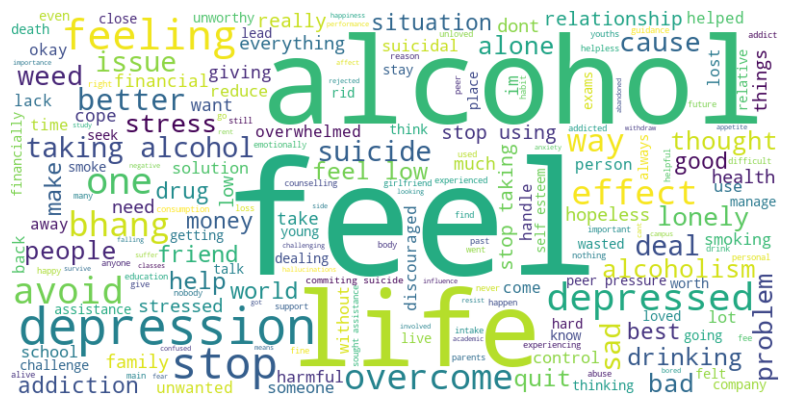

In [27]:
# Convert the column into a single string
train_text = " ".join(train_df['clean_text'].astype(str))

# Generate the word cloud in the train data
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(train_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()

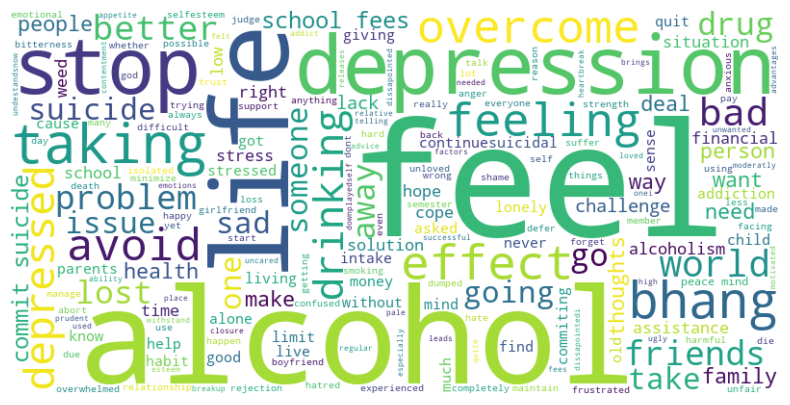

In [28]:
# Convert the column into a single string
test_text = " ".join(test_df['clean_text'].astype(str))

# Generate the word cloud in the test data
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(test_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()

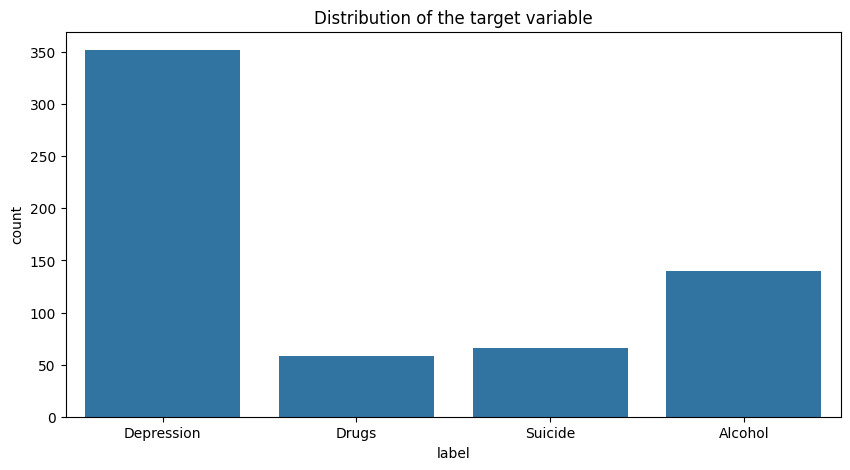

In [29]:
# Plot the distribution of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of the target variable')
plt.show()

In [87]:
# Get the max length for padding and truncation
max_length = train_df['clean_text'].apply(lambda x: len(str(x).split())).max()
print("Max length of cleaned text:", max_length)


Max length of cleaned text: 17


In [88]:
# Define max words (vocab size)
max_words = 1000  # Adjust based on dataset size

# Initialize tokenizer with vocabulary limit and OOV token
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")  

# Fit tokenizer on the cleaned text
tokenizer.fit_on_texts(train_df['clean_text'])

# Get actual vocabulary size (should be <= max_words)
vocab_size = min(max_words, len(tokenizer.word_index) + 1)  # +1 for OOV token
print("Vocabulary size:", vocab_size)

Vocabulary size: 762


In [89]:
# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test = tokenizer.texts_to_sequences(test_df["clean_text"])

# Padding the sequences
max_len = max_length  # Maximum sequence length
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding="post", truncating="post" )
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding="post", truncating="post")

print("Tokenized & Padded shape:", X_train_padded.shape, X_test_padded.shape)  # (num_samples, max_length)

# Display processed data samples
train_df[["text", "clean_text"]].head()

Tokenized & Padded shape: (616, 17) (309, 17)


,text,clean_text
0,I feel that it was better I dieAm happy,feel better dieam happy
1,Why do I get hallucinations?,get hallucinations
2,I am stresseed due to lack of financial suppor...,stresseed due lack financial support school
3,Why is life important?,life important
4,How could I be helped to go through the depres...,could helped go depression


In [90]:
# Encode the target variable labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["label"])

# One-hot encode labels for categorical classification
y_train = to_categorical(train_labels_encoded)

# Display label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping


{'Alcohol': np.int64(0),
 'Depression': np.int64(1),
 'Drugs': np.int64(2),
 'Suicide': np.int64(3)}

## Modelling
### 1. Long Short Term Memory (LSTM)

In [104]:
# Define model parameters
embedding_dim = 128  # Size of word embeddings
lstm_units = 128  # Number of LSTM units
num_classes = len(label_mapping)  
input_length = max_length

# Define LSTM model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),  # Dropout applied to embeddings
    
    # First LSTM layer
    LSTM(128, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01)),  
    LayerNormalization(),  # Normalization for better stability

    # Second LSTM layer
    LSTM(64, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01)),  
    
    # Fully Connected Layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),  
    Dropout(0.5),  # Increased dropout for better regularization

    # Output Layer (for multiclass classification)
    Dense(num_classes, activation="softmax")
])

# Compile the model
model_lstm.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005, decay=1e-6),  # Adaptive learning rate decay),
              metrics=['accuracy'])

model_lstm.build(input_shape=(None, max_len))

# Model summary
model_lstm.summary()


c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 17, 128)        │        97,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_17            │ (None, 17, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 17, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 17, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,204 (1.08 MB)

 Trainable params: 283,204 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Fit and train the model

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train model
history = model_lstm.fit(X_train_padded, y_train,
                    epochs=15, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_reduction])

# Save the trained model
#model.save("lstm_model.keras")


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.4409 - loss: 5.4877 - val_accuracy: 0.5161 - val_loss: 5.0247 - learning_rate: 5.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5685 - loss: 4.8334 - val_accuracy: 0.5161 - val_loss: 4.4669 - learning_rate: 5.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5715 - loss: 4.2629 - val_accuracy: 0.5161 - val_loss: 4.0028 - learning_rate: 5.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5881 - loss: 3.8191 - val_accuracy: 0.5161 - val_loss: 3.5507 - learning_rate: 5.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6056 - loss: 3.3881 - val_accuracy: 0.5242 - val_loss: 3.2892 - learning_rate: 5.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7091 - loss: 2.9210 - val_accuracy: 0.6855 - val_loss: 2.6955 - learning_rate: 5.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.762

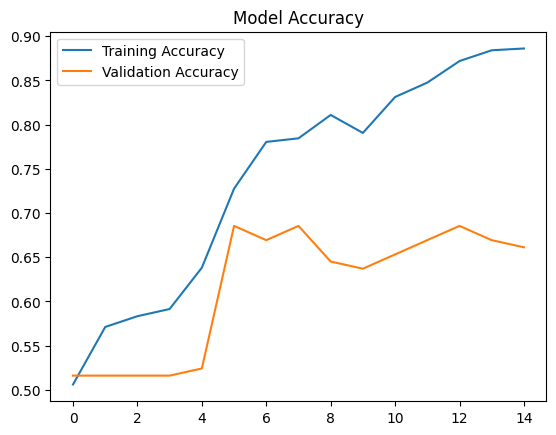

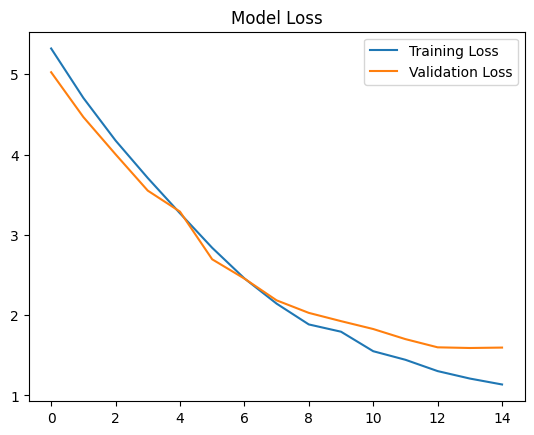

In [106]:
# visualize the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

### 2. Gated Recurrent  Unit (GRU)

In [96]:
# Define GRU model with enhancements
model_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    SpatialDropout1D(0.3),  # Dropout applied to word embeddings
    Bidirectional(GRU(128, return_sequences=True, activation="relu", kernel_regularizer=l2(0.01))),  # First BiGRU layer
    LayerNormalization(),  # Normalize activations to improve stability
    Bidirectional(GRU(64, activation="relu", kernel_regularizer=l2(0.01))),  # Second BiGRU layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),  # Fully connected layer with L2 regularization
    Dropout(0.4),  # Dropout to prevent overfitting
    Dense(num_classes, activation="softmax")  # Output layer
    ])
    
model_gru.compile(loss="categorical_crossentropy",
            optimizer=Adam(learning_rate=0.0005, decay=1e-6),  # Adaptive learning rate decay
            metrics=["accuracy"])

# Build the GRU model
model_gru.build(input_shape=(None, max_length))  

# Show model summary
model_gru.summary()

c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 17, 128)        │        97,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_14            │ (None, 17, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 17, 256)        │       198,144 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 17, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 128)            │       123,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,356 (1.63 MB)

 Trainable params: 428,356 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Fit and train the model

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train model
history = model_gru.fit(X_train_padded, y_train,
                    epochs=15, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_reduction])

# Save the trained model
#model.save("gru_model.keras")

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.4916 - loss: 9.9477 - val_accuracy: 0.5161 - val_loss: 8.8032 - learning_rate: 5.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5951 - loss: 8.4297 - val_accuracy: 0.5887 - val_loss: 7.5025 - learning_rate: 5.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6709 - loss: 7.1202 - val_accuracy: 0.6452 - val_loss: 6.4179 - learning_rate: 5.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7416 - loss: 6.0083 - val_accuracy: 0.6532 - val_loss: 5.4620 - learning_rate: 5.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7774 - loss: 5.1438 - val_accuracy: 0.7177 - val_loss: 4.7010 - learning_rate: 5.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8068 - loss: 4.2847 - val_accuracy: 0.7097 - val_loss: 4.1044 - learning_rate: 5.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.852

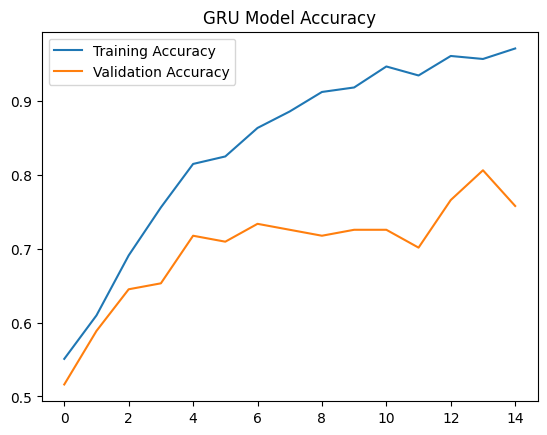

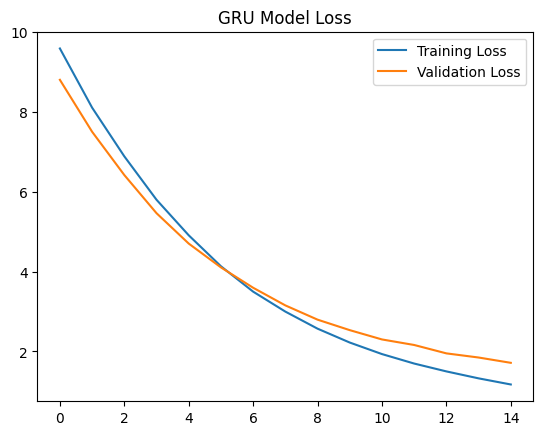

In [98]:
# visualize the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('GRU Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('GRU Model Loss')
plt.show()

### 3. Bidirectional LSTM

In [ ]:
# Define model parameters
embedding_dim = 128  # Size of word embeddings
lstm_units = 128  # Number of LSTM units
num_classes = len(label_mapping)
input_length = max_length

# Define model
model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),  # Drop entire word embeddings with 30% probability
    Bidirectional(LSTM(128, return_sequences=True, activation="relu", kernel_regularizer=l2(0.01))),  # First BiLSTM with L2
    LayerNormalization(),  # Normalization for stable training
    Bidirectional(LSTM(64, activation="relu", kernel_regularizer=l2(0.01))),  # Second BiLSTM
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),  # Fully connected layer with L2 regularization
    Dropout(0.4),  # Dropout to prevent overfitting
    Dense(num_classes, activation="softmax")  # Output layer for multiclass classification
])

# Compile the model with an adaptive learning rate
model_bilstm.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# Build the BiLSTM model
model_bilstm.build(input_shape=(None, max_length))

# Show model summary
model_bilstm.summary()


c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 17, 128)        │        97,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_12            │ (None, 17, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 17, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 17, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 534,084 (2.04 MB)

 Trainable params: 534,084 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit and train the model

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train model
history = model_bilstm.fit(X_train_padded, y_train,
                    epochs=15, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_reduction])

# Save the trained model
#model.save("bilstm_model.keras")

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.4832 - loss: 10.9006 - val_accuracy: 0.5161 - val_loss: 9.6151 - learning_rate: 5.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5174 - loss: 9.2236 - val_accuracy: 0.5161 - val_loss: 8.1920 - learning_rate: 5.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6110 - loss: 7.7335 - val_accuracy: 0.6290 - val_loss: 6.8740 - learning_rate: 5.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6937 - loss: 6.4386 - val_accuracy: 0.6774 - val_loss: 5.6857 - learning_rate: 5.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7631 - loss: 5.3398 - val_accuracy: 0.6855 - val_loss: 4.8325 - learning_rate: 5.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7604 - loss: 4.5043 - val_accuracy: 0.6694 - val_loss: 4.1607 - learning_rate: 5.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.82

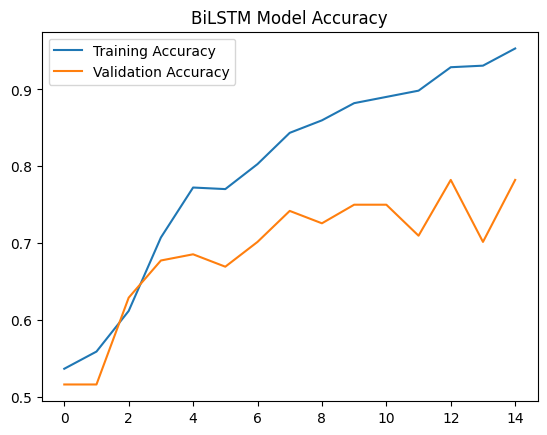

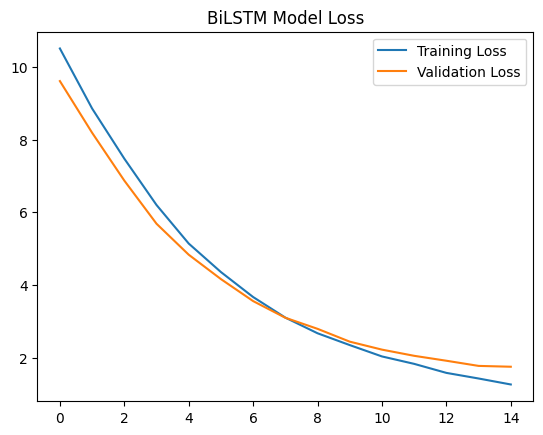

In [93]:
# visualize the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('BiLSTM Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('BiLSTM Model Loss')
plt.show()

### 4. BiLSTM and GRU

In [99]:
# Define the Hybrid LSTM-GRU model
model_hybrid = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),  # Dropout applied to embeddings

    # First Bidirectional LSTM Layer
    Bidirectional(LSTM(128, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01))),  
    LayerNormalization(),  # Normalization for better training stability

    # Second Bidirectional GRU Layer
    Bidirectional(GRU(64, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01))),
    
    # Fully Connected Layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),  
    Dropout(0.5),  # Increased dropout for regularization

    # Output Layer (for multiclass classification)
    Dense(num_classes, activation="softmax")
])

# Compile the model
model_hybrid.compile(loss="categorical_crossentropy", 
                     optimizer=Adam(learning_rate=0.001), 
                     metrics=["accuracy"])


# Build model
model_hybrid.build(input_shape=(None, max_length))

# Model summary
model_hybrid.summary()



c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 17, 128)        │        97,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_15            │ (None, 17, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 17, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 17, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 128)            │       123,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,380 (1.88 MB)

 Trainable params: 493,380 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Fit and train the model

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train model
history = model_hybrid.fit(X_train_padded, y_train,
                    epochs=15, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler])

# Save the trained model
#model.save("model_hybrid.keras")

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.5363 - loss: 9.8374 - val_accuracy: 0.5161 - val_loss: 7.8494 - learning_rate: 0.0010
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6037 - loss: 7.2174 - val_accuracy: 0.6210 - val_loss: 5.7454 - learning_rate: 0.0010
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7559 - loss: 5.1569 - val_accuracy: 0.7016 - val_loss: 4.2282 - learning_rate: 0.0010
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7792 - loss: 3.8528 - val_accuracy: 0.7097 - val_loss: 3.3034 - learning_rate: 0.0010
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8532 - loss: 2.9075 - val_accuracy: 0.7177 - val_loss: 2.6726 - learning_rate: 0.0010
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8835 - loss: 2.3005 - val_accuracy: 0.7823 - val_loss: 2.2004 - learning_rate: 0.0010
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9082 - loss: 1.8628 - val_a

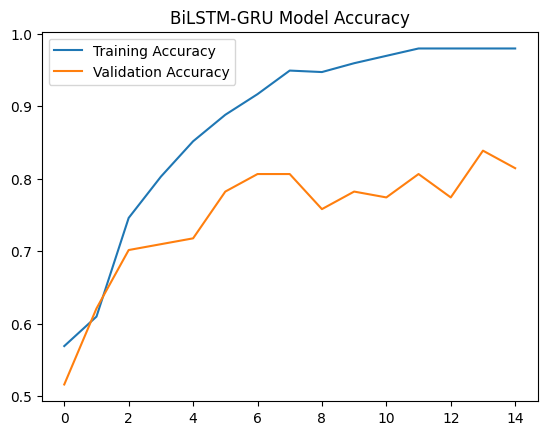

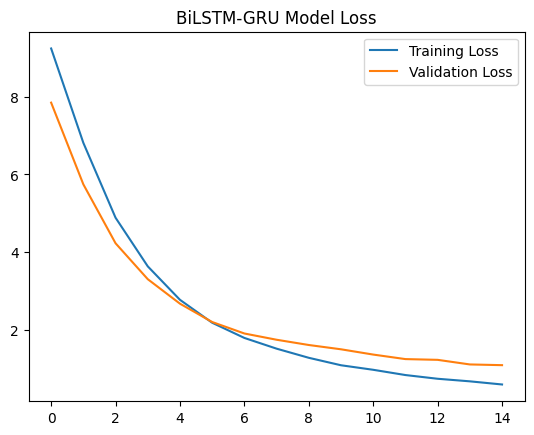

In [101]:
# visualize the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('BiLSTM-GRU Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('BiLSTM-GRU Model Loss')
plt.show()

## Evaluation of the models

In [109]:
# Compare the four models
print(f'lstm model loss and accuracy:{model_lstm.evaluate(X_train_padded, y_train)}')
print(f'bilstm model loss and accuracy:{model_bilstm.evaluate(X_train_padded, y_train)}')
print(f'gru model loss and accuracy:{model_gru.evaluate(X_train_padded, y_train)}')
print(f'hybrid model loss and accuracy:{model_hybrid.evaluate(X_train_padded, y_train)}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9263 - loss: 1.0869
lstm model loss and accuracy:[1.1790120601654053, 0.8863636255264282]
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8107 - loss: 0.3254
bilstm model loss and accuracy:[0.3845072090625763, 0.7922077775001526]
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9799 - loss: 1.0797
gru model loss and accuracy:[1.1949418783187866, 0.9383116960525513]
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9819 - loss: 0.5431
hybrid model loss and accuracy:[0.6392320394515991, 0.9496753215789795]


- The hybrid model seems to perform better with an accuracy of 98% 

## Predictions